# Projeto Machine Learning Matemática - Prevendo Infartos

## Carregando Dados e Definindo Funções

In [ ]:
import re
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from pprint import pprint
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance
from pandas.api.types import is_numeric_dtype
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import  SVC
from sklearn import metrics
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_auc_score, balanced_accuracy_score, roc_curve
import optuna.logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

from sklearn.preprocessing import StandardScaler


%matplotlib inline


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

sns.set_theme()

In [ ]:
#@title Check missing values count and percent
def check_missing(dataframe, threshold=50, show_top=False):
    # Create a copy of the DataFrame to avoid modifying the original data
    df = dataframe.copy()

    # Count the missing values for each column and sort in descending order
    count = df.isnull().sum().sort_values(ascending=False)

    # Calculate the percentage of missing values for each column and sort in descending order
    percent = (df.isnull().sum() / df.shape[0]).sort_values(ascending=False) * 100

    # Create a DataFrame with the count and percentage of missing values for each column
    missing_data = pd.concat([count, percent], axis=1, keys=["MISSING", "PERCENTAGE_MISSING"])

    # Select columns with missing values above the threshold
    top_missing = missing_data.loc[missing_data["PERCENTAGE_MISSING"] > threshold, :]

    if show_top:
        return top_missing
    else:
        # Return a list of column names with missing values above the threshold
        return top_missing.index.tolist()

In [ ]:
#@title Process Missing Values
def process_missing_values(df, limit_percentage, statistic):
    import pandas as pd
    """
    Processes missing values in a DataFrame.
    Arguments:

    df: DataFrame - The DataFrame containing the data.
    limit_percentage: float - The limit (in percentage) for the proportion of missing values.
    statistic: str - The statistic to be used to replace the missing values.
    It can be 'mean', 'median', 'mode', or 'exclude'.
    Returns:
    DataFrame - The DataFrame with the processed missing values.
    """
    # Calculates the number of missing values in each column
    missing_counts = df.isna().sum()

    # Calculates the proportion of missing values relative to the total column length
    missing_percentages = missing_counts / len(df)

    # Loop through the columns of the DataFrame
    for column in df.columns:
        # Checks if the proportion of missing values in the column is greater than the limit
        if missing_percentages[column] > limit_percentage:
            # Removes the column from the DataFrame if the proportion is greater than the limit
            df = df.drop(column, axis=1)
        else:
            # Replaces the missing values according to the chosen statistic
            if statistic == 'mean':
                df[column].fillna(df[column].mean(), inplace=True)
            elif statistic == 'median':
                df[column].fillna(df[column].median(), inplace=True)
            elif statistic == 'mode':
                df[column].fillna(df[column].mode()[0], inplace=True)
            elif statistic == 'exclude':
                df = df.dropna(subset=[column])

    return df
# df_num = df.loc[:,df.dtypes != 'object']
# process_missing_values(df_num,limit_percentage=0.5,statistic='median')

In [ ]:
#@title Function to Detect Multicolinearity
def detect_multicollinearity(dataframe, threshold=0.7, plot=False):
    """
    Identifies multicollinearity in a DataFrame based on a threshold (default: 0.7).
    Multicollinearity occurs when two predictor variables have a high correlation.
    Identifying which variables have this issue helps in the analysis of variable selection
    and further treatment (such as removal, standardization, or dimensionality reduction).

    Arguments:
    - dataframe: DataFrame - The DataFrame containing the data.
    - threshold: float, optional - The correlation threshold to identify multicollinearity.
                                   Default is 0.7.
    - plot: bool, optional - Specifies whether to plot the correlation matrix.
                             Default is False.

    Returns:
    list - A list of tuples containing the pairs of columns with multicollinearity
           and their corresponding correlation values.
    """

    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Calculate the correlation matrix
    correlation_matrix = dataframe.corr().abs()

    # Get the list of columns with high correlation (greater than or equal to the threshold)
    collinear_columns = []

    # Iterate over the correlation matrix
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            if correlation_matrix.iloc[i, j] >= threshold:
                # Add the pair of columns with high correlation to the list
                column_i = correlation_matrix.columns[i]
                column_j = correlation_matrix.columns[j]
                correlation_value = correlation_matrix.iloc[i, j]
                collinear_columns.append((column_i, column_j, correlation_value))

    # Print the pairs of columns with multicollinearity and their correlation values
    for pair in collinear_columns:
        print(f"Multicollinearity detected between: {pair[0]} and {pair[1]}. Correlation: {pair[2]}")

    # Plot the correlation matrix if requested
    if plot:
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    return collinear_columns
# df_num = df.loc[:,df.dtypes != 'object']
# detect_multicollinearity(df_num.iloc[:,0:8],0.7,plot=True) # Selecting the first 8 rows to show

In [ ]:
def get_metrics(name_model_dict, X, y, threshold=0.5):
    models_dict = {}
    thresholds = {}
    alphas = {}
    for name, model in name_model_dict.items():
        if isinstance(model, list):
            model_obj = model[0]
            threshold_model = model[1]
            alpha_model = model[2] if len(model) > 2 else None
            y_prob = model_obj.predict_proba(X)[:, 1]
            y_pred = (y_prob >= threshold_model).astype('int')
            thresholds[name] = threshold_model
            alphas[name] = alpha_model
        else:
            model_obj = model
            y_prob = model_obj.predict_proba(X)[:, 1]
            y_pred = (y_prob >= threshold).astype('int')
            thresholds[name] = threshold

        models_dict[name] = (y_pred, y_prob)

    def get_metrics_df(models_dict, thresholds, alphas, y_true):
        metrics_dict = {
            "Overall AUC": (
                lambda x: roc_auc_score(y_true, x), False),
            "Balanced Accuracy": (
                lambda x: balanced_accuracy_score(y_true, x), True),
            "Accuracy": (
                lambda x: accuracy_score(y_true, x), True),
            "Precision": (
                lambda x: precision_score(y_true, x), True),
            "Recall": (
                lambda x: recall_score(y_true, x), True),
            "F1": (
                lambda x: f1_score(y_true, x), True),
            "Specificity": (
                lambda x: recall_score(y_true, x, pos_label=0), True),
            "Sensitivity": (
                lambda x: recall_score(y_true, x, pos_label=1), True),
                " ------": (lambda x: "", True),
        }
        df_dict = {}
        for metric_name, (metric_func, use_preds) in metrics_dict.items():
            df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores)
                                    for model_name, (preds, scores) in models_dict.items()]
        df_dict["Threshold"] = [thresholds[model_name] for model_name in models_dict.keys()]
        df_dict["Alpha"] = [alphas[model_name] for model_name in models_dict.keys()]
        return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

    return get_metrics_df(models_dict, thresholds, alphas, y)

In [ ]:
df = pd.read_csv("C:\\Users\\decmg\\OneDrive\\Documentos\\Material Disciplinas\\ML-Mat.Ap(Do Valle)\\Monografia\\healthcare-dataset-stroke-data.csv",sep=',',encoding='utf-8')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Informações Iniciais do Dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
df_b = df.drop(['id'],axis=1)
def agregate_categorical_Vs_Numeric(df,columns):
    columns = df.columns
    for k in df.loc[:,df_b.dtypes != 'object'].columns:
        for i in df.loc[:,df_b.dtypes == 'object'].columns:
            display(df.groupby([i]).agg({k:['count','mean','median','std','min','max']}))

In [ ]:
agregate_categorical_Vs_Numeric(df_b)

age                                          
       count       mean median        std    min   max
gender                                                
Female  2994  43.757395   44.0  21.966561   0.08  82.0
Male    2115  42.483385   46.0  23.484066   0.08  82.0
Other      1  26.000000   26.0        NaN  26.00  26.0

age                                          
             count       mean median        std    min   max
ever_married                                                
No            1757  22.014229   18.0  18.474467   0.08  82.0
Yes           3353  54.342082   54.0  15.527678  18.00  82.0

age                                          
              count       mean median        std    min   max
work_type                                                    
Govt_job        657  50.879756   51.0  15.438879  14.00  82.0
Never_worked     22  16.181818   16.0   2.342899  13.00  23.0
Private        2925  45.503932   45.0  18.444200   8.00  82.0
Self-employed   819  60.201465   63.0  16.835961   7.00  82.0
children        687   6.841339    6.0   4.533364   0.08  16.0

age                                         
               count       mean median        std   min   max
Residence_type                                               
Rural           2514  42.900811   44.0  22.462089  0.08  82.0
Urban           2596  43.542126   45.0  22.757380  0.08  82.0

age                                          
                count       mean median        std    min   max
smoking_status                                                 
Unknown          1544  30.229922   23.0  25.055556   0.08  82.0
formerly smoked   885  54.929944   57.0  17.641723  10.00  82.0
never smoked     1892  46.744715   47.0  19.769584  10.00  82.0
smokes            789  47.096324   47.0  16.413002  10.00  82.0

hypertension                                   
              count      mean median       std min max
gender                                                
Female         2994  0.092184    0.0  0.289334   0   1
Male           2115  0.104965    0.0  0.306580   0   1
Other             1  0.000000    0.0       NaN   0   0

hypertension                                   
                    count      mean median       std min max
ever_married                                                
No                   1757  0.030165    0.0  0.171090   0   1
Yes                  3353  0.132717    0.0  0.339319   0   1

hypertension                                   
                     count      mean median       std min max
work_type                                                    
Govt_job               657  0.111111    0.0  0.314509   0   1
Never_worked            22  0.000000    0.0  0.000000   0   0
Private               2925  0.096068    0.0  0.294735   0   1
Self-employed          819  0.175824    0.0  0.380903   0   1
children               687  0.000000    0.0  0.000000   0   0

hypertension                                   
                      count      mean median       std min max
Residence_type                                                
Rural                  2514  0.099841    0.0  0.299847   0   1
Urban                  2596  0.095146    0.0  0.293474   0   1

hypertension                                   
                       count      mean median       std min max
smoking_status                                                 
Unknown                 1544  0.033679    0.0  0.180459   0   1
formerly smoked          885  0.135593    0.0  0.342550   0   1
never smoked            1892  0.122622    0.0  0.328089   0   1
smokes                   789  0.119138    0.0  0.324156   0   1

heart_disease                                   
               count      mean median       std min max
gender                                                 
Female          2994  0.037742    0.0  0.190604   0   1
Male            2115  0.077069    0.0  0.266763   0   1
Other              1  0.000000    0.0       NaN   0   0

heart_disease                                   
                     count      mean median       std min max
ever_married                                                 
No                    1757  0.018213    0.0  0.133759   0   1
Yes                   3353  0.072771    0.0  0.259798   0   1

heart_disease                                   
                      count      mean median       std min max
work_type                                                     
Govt_job                657  0.054795    0.0  0.227752   0   1
Never_worked             22  0.000000    0.0  0.000000   0   0
Private                2925  0.054017    0.0  0.226090   0   1
Self-employed           819  0.098901    0.0  0.298712   0   1
children                687  0.001456    0.0  0.038152   0   1

heart_disease                                   
                       count      mean median       std min max
Residence_type                                                 
Rural                   2514  0.053302    0.0  0.224679   0   1
Urban                   2596  0.054700    0.0  0.227437   0   1

heart_disease                                   
                        count      mean median       std min max
smoking_status                                                  
Unknown                  1544  0.031088    0.0  0.173612   0   1
formerly smoked           885  0.087006    0.0  0.282003   0   1
never smoked             1892  0.047569    0.0  0.212908   0   1
smokes                    789  0.077313    0.0  0.267257   0   1

avg_glucose_level                                                
                   count        mean   median        std     min     max
gender                                                                  
Female              2994  104.057809   90.755  43.590651   55.12  267.76
Male                2115  109.088520   93.550  47.434840   55.22  271.74
Other                  1  143.330000  143.330        NaN  143.33  143.33

avg_glucose_level                                            
                         count       mean median        std    min     max
ever_married                                                              
No                        1757   96.44815  89.04  32.355385  55.12  266.59
Yes                       3353  111.23031  93.55  50.018778  55.22  271.74

avg_glucose_level                                             
                          count        mean median        std    min     max
work_type                                                                   
Govt_job                    657  107.779772  91.93  47.697200  55.27  266.59
Never_worked                 22   96.042727  86.02  28.697132  59.99  161.28
Private                    2925  106.796844  91.92  45.886102  55.12  271.74
Self-employed               819  112.645446  93.60  51.719490  55.23  267.61
children                    687   94.400277  90.22  26.658955  55.34  219.81

avg_glucose_level                                              
                           count        mean  median        std    min     max
Residence_type                                                                
Rural                       2514  106.375235  92.955  45.218348  55.12  271.74
Urban                       2596  105.927307  90.770  45.354246  55.22  267.76

avg_glucose_level                                        \
                            count        mean  median        std    min   
smoking_status                                                            
Unknown                      1544   99.601541  90.420  36.606195  55.23   
formerly smoked               885  112.886079  92.590  52.256627  55.27   
never smoked                 1892  107.558092  92.215  46.679640  55.12   
smokes                        789  108.017440  93.880  47.280803  55.32   

                         
                    max  
smoking_status           
Unknown          260.85  
formerly smoked  267.76  
never smoked     267.60  
smokes           271.74

bmi                                        
       count       mean median       std   min   max
gender                                              
Female  2897  29.065758   27.8  8.110783  10.3  78.0
Male    2011  28.647936   28.4  7.464493  11.5  97.6
Other      1  22.400000   22.4       NaN  22.4  22.4

bmi                                        
             count       mean median       std   min   max
ever_married                                              
No            1705  25.214721   23.5  7.783018  10.3  97.6
Yes           3204  30.850749   29.6  7.159654  11.3  92.0

bmi                                        
              count       mean median       std   min   max
work_type                                                  
Govt_job        630  30.522063  29.40  6.919375  16.0  57.7
Never_worked     22  25.545455  23.15  7.441757  14.6  44.9
Private        2811  30.304625  28.90  7.582663  11.5  97.6
Self-employed   775  30.211871  29.40  6.687689  11.3  64.8
children        671  20.038003  18.90  4.540639  10.3  41.7

bmi                                        
               count       mean median       std   min   max
Residence_type                                              
Rural           2419  28.894212   28.1  7.918061  10.3  97.6
Urban           2490  28.892289   28.0  7.792985  11.3  78.0

bmi                                        
                count       mean median       std   min   max
smoking_status                                               
Unknown          1483  25.666352   24.3  8.144856  10.3  97.6
formerly smoked   837  30.747192   29.8  6.981149  15.0  56.1
never smoked     1852  29.982559   28.6  7.463217  11.5  92.0
smokes            737  30.543555   29.1  7.192536  15.7  78.0

stroke                                   
        count      mean median       std min max
gender                                          
Female   2994  0.047094    0.0  0.211876   0   1
Male     2115  0.051064    0.0  0.220180   0   1
Other       1  0.000000    0.0       NaN   0   0

stroke                                   
              count      mean median       std min max
ever_married                                          
No             1757  0.016505    0.0  0.127445   0   1
Yes            3353  0.065613    0.0  0.247641   0   1

stroke                                   
               count      mean median       std min max
work_type                                              
Govt_job         657  0.050228    0.0  0.218582   0   1
Never_worked      22  0.000000    0.0  0.000000   0   0
Private         2925  0.050940    0.0  0.219913   0   1
Self-employed    819  0.079365    0.0  0.270473   0   1
children         687  0.002911    0.0  0.053916   0   1

stroke                                   
                count      mean median       std min max
Residence_type                                          
Rural            2514  0.045346    0.0  0.208103   0   1
Urban            2596  0.052003    0.0  0.222076   0   1

stroke                                   
                 count      mean median       std min max
smoking_status                                           
Unknown           1544  0.030440    0.0  0.171851   0   1
formerly smoked    885  0.079096    0.0  0.270041   0   1
never smoked      1892  0.047569    0.0  0.212908   0   1
smokes             789  0.053232    0.0  0.224638   0   1

In [ ]:
df.stroke.count()

5110

In [ ]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
# Desbalanceamento
df.stroke.value_counts(),df.stroke.value_counts()[1]/df.stroke.count()

(stroke
 0    4861
 1     249
 Name: count, dtype: int64,
 0.0487279843444227)

### Missing Treatment

In [ ]:
#Percentage of Row Missing for the Columns
check_missing(df,threshold=0,show_top=True)

,MISSING,PERCENTAGE_MISSING
bmi,201,3.933464


In [ ]:
df_process = process_missing_values(df=df,limit_percentage=0.7,statistic='exclude')
df_process.isna().sum().sum()

0

### Multicolinearity Treatment

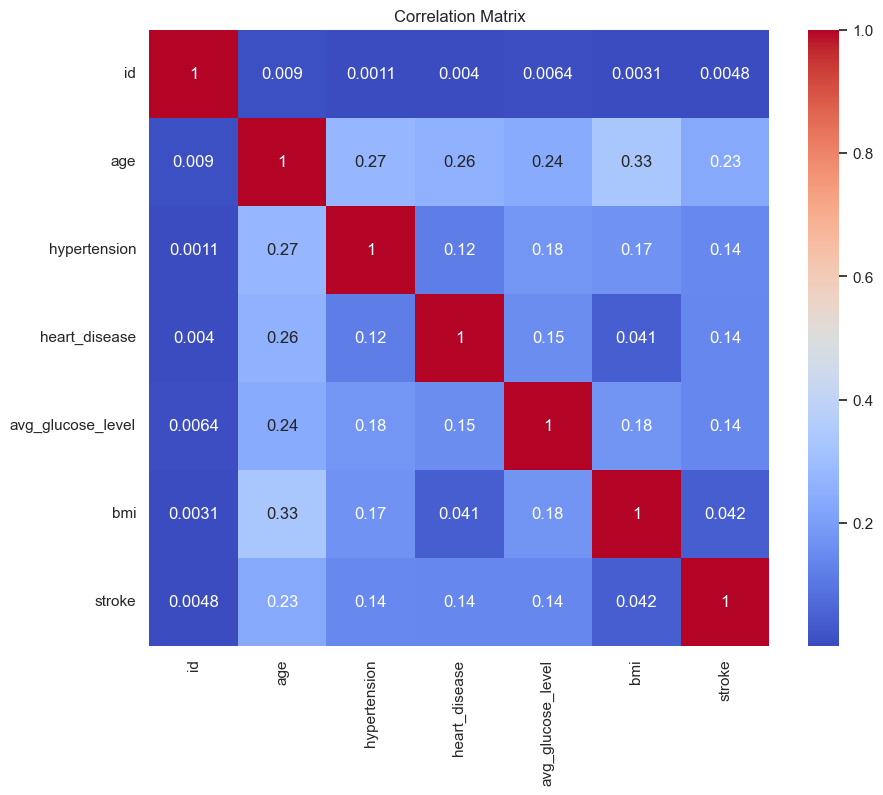

[]

In [ ]:
detect_multicollinearity(df_process.loc[:,df_process.dtypes !='object'],threshold=0.8,plot=True)

Sem presença considerável de multicolinearidade

In [ ]:
#Não acrescenta na Análise
df_process.drop(['id'],axis=1,inplace=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import random

def PlotHistplot(df, num_cols_per_row=2, f=False):
    num_cols = len(df.columns)

    # Define o número de linhas para os subplots
    num_rows = (num_cols // num_cols_per_row) + (num_cols % num_cols_per_row)

    # Configura a figura e os eixos dos subplots
    fig, axes = plt.subplots(num_rows, num_cols_per_row, figsize=(15, 5*num_rows))
    axes = axes.flatten()

    # Itera sobre as colunas e plota os histogramas
    for i, col in enumerate(df.columns):
        ax = axes[i]

        if df[col].nunique() > 30:
            f = True
        else:
            f = False

        colors = [random.choice(sns.color_palette()) for _ in range(100)]
        sns.histplot(df, x=str(col), color=colors[0], kde=f, stat='count', ax=ax)
        ax.set_title(col)

    # Ajusta o layout para evitar sobreposição
    plt.tight_layout()
    plt.show()


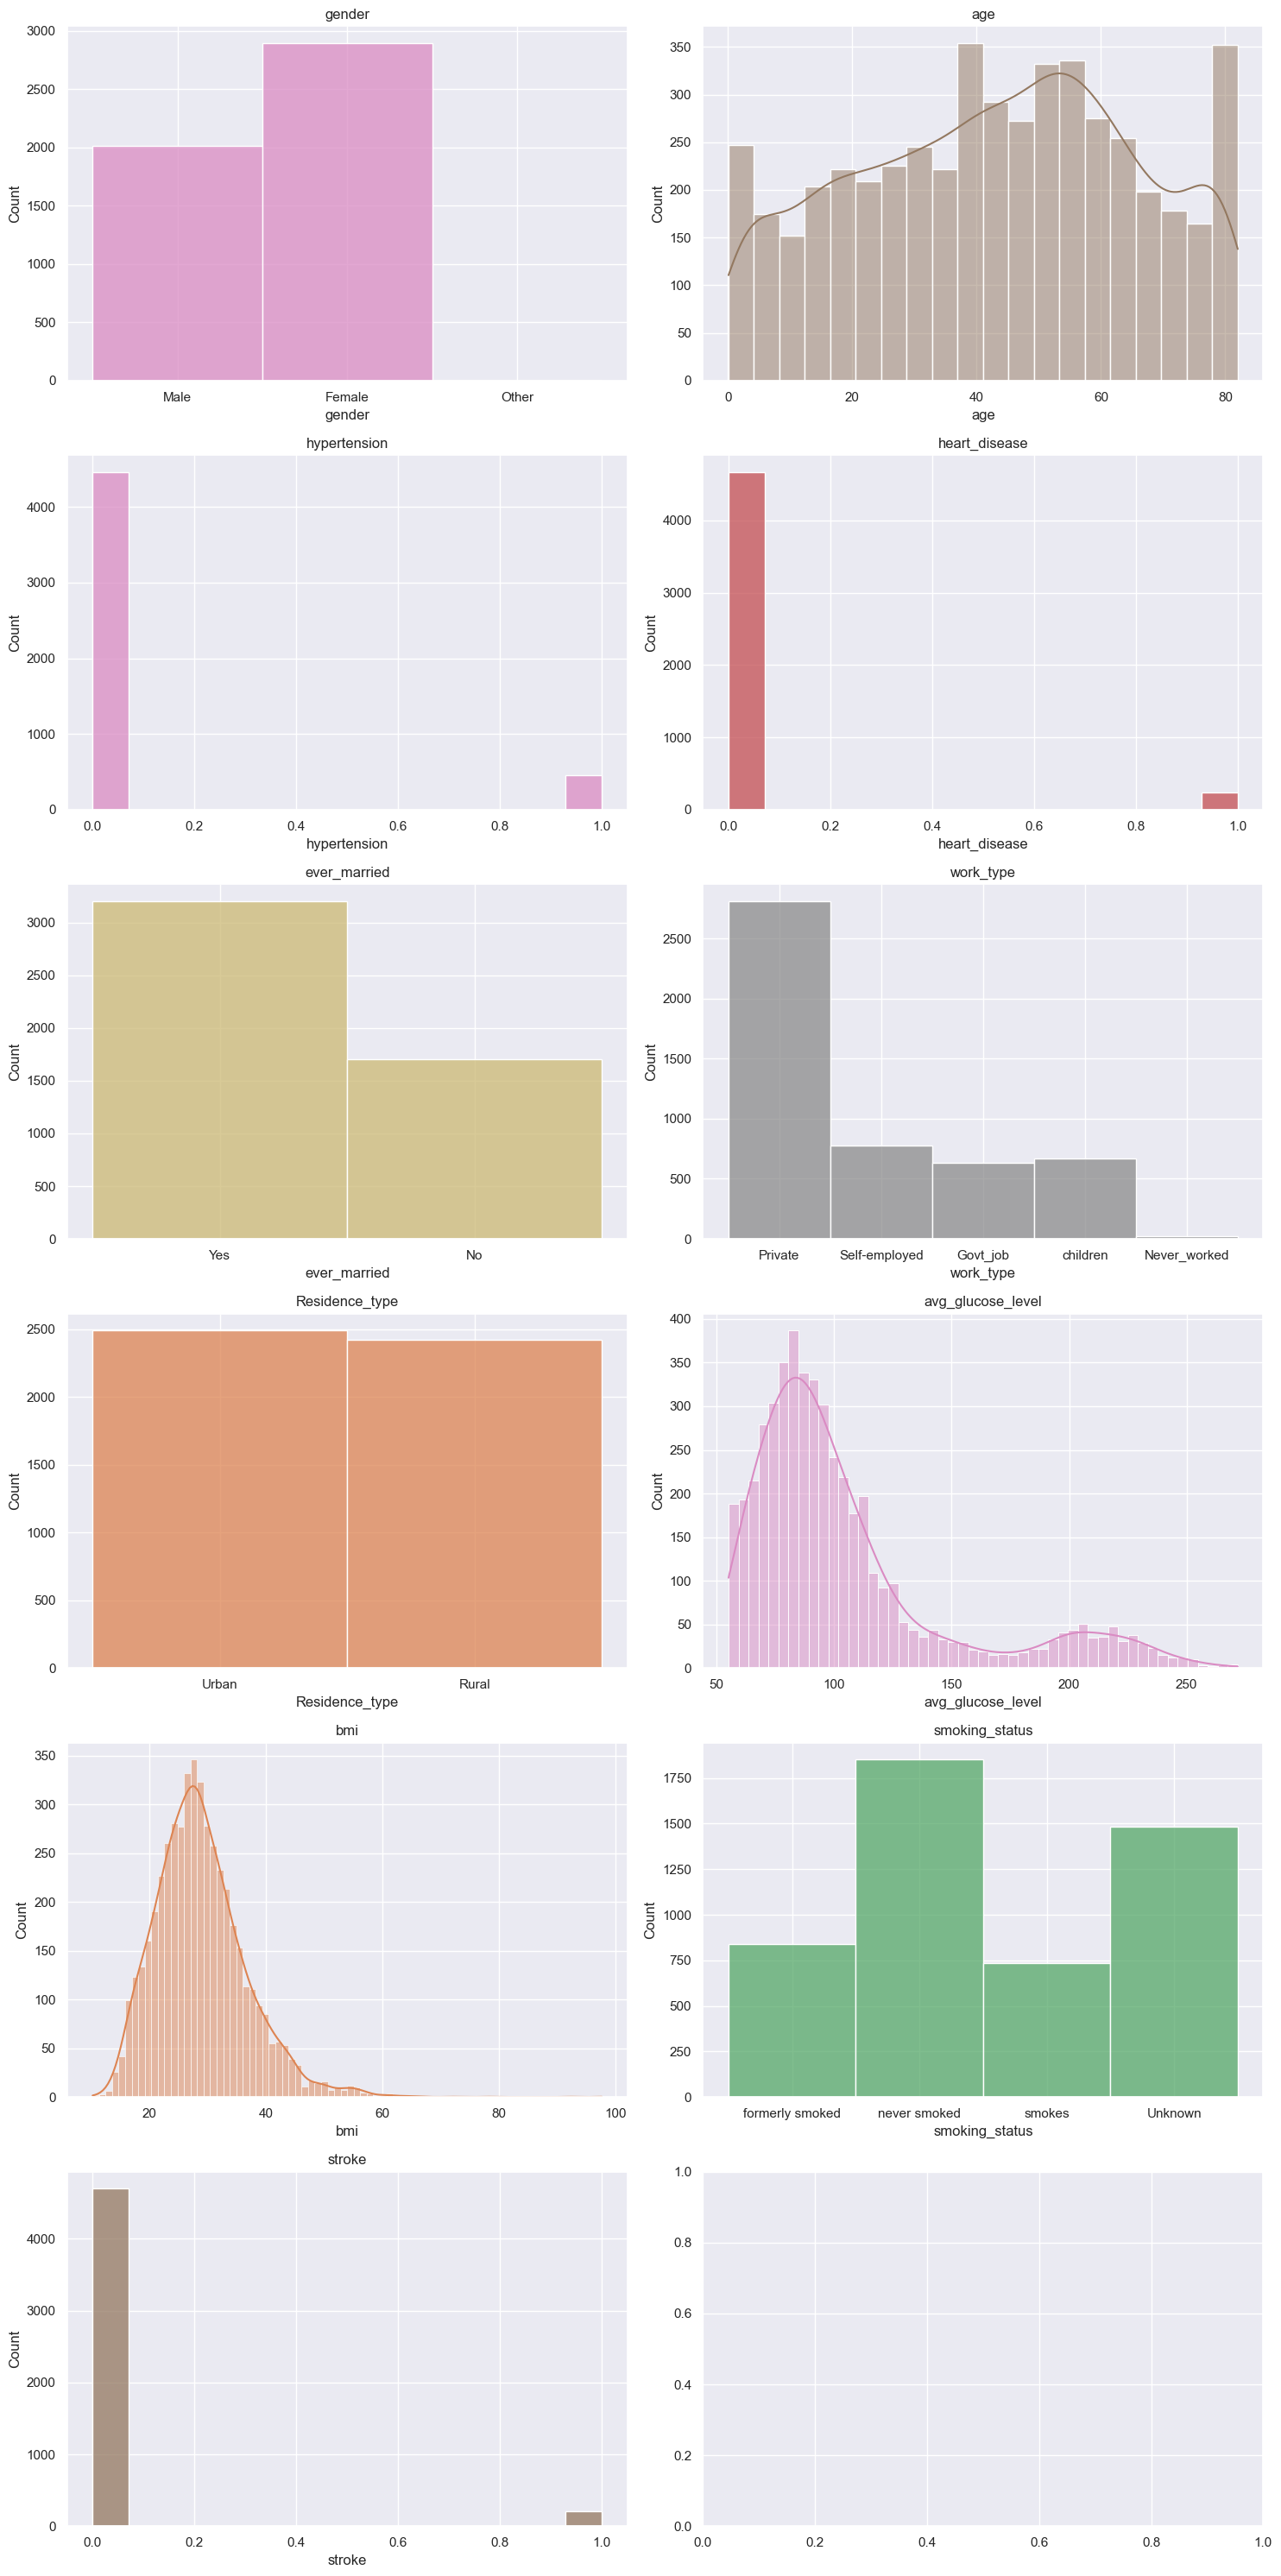

In [ ]:
PlotHistplot(df_process,num_cols_per_row=2)

In [ ]:
df_process.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

## Escalonamento das Numéricas

In [ ]:
def padronizar_dataframe(df):
    if df.empty:
        print("O DataFrame está vazio.")
        return df

    colunas_numericas = df.select_dtypes(include=['float64', 'int64','float32','int32']).columns

    if len(colunas_numericas) == 0:
        print("Não há colunas numéricas no DataFrame.")
        return df
    scaler = StandardScaler()
    df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

    return df

In [ ]:
df_scaler = df_process.copy()

In [ ]:
df_scaler = padronizar_dataframe(df_scaler)

In [ ]:
df_scaler.stroke = df_process.stroke
df_scaler.hypertension = df_process.hypertension
df_scaler.heart_disease = df_process.heart_disease
df_scaler

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.070138,0,1,Yes,Private,Urban,2.777698,0.981345,formerly smoked,1
2,Male,1.646563,0,1,Yes,Private,Rural,0.013842,0.459269,never smoked,1
3,Female,0.272012,0,0,Yes,Private,Urban,1.484132,0.701207,smokes,1
4,Female,1.602222,1,0,Yes,Self-employed,Rural,1.549193,-0.623083,never smoked,1
5,Male,1.690903,0,0,Yes,Private,Urban,1.821368,0.013595,formerly smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5104,Female,-1.324241,0,0,No,children,Rural,-0.050094,-1.310695,Unknown,0
5106,Female,1.690903,0,0,Yes,Self-employed,Urban,0.447882,1.414286,never smoked,0
5107,Female,-0.348753,0,0,Yes,Self-employed,Rural,-0.502369,0.217332,never smoked,0
5108,Male,0.360692,0,0,Yes,Private,Rural,1.372920,-0.419346,formerly smoked,0


## Encoder das Categóricas

In [ ]:
# def encode_categorical_columns(df):
#     _
#     encoded_df = df.copy()
#     label_encoder = LabelEncoder()
#     encoded_columns = {}

#     for column in df.columns:
#         if df[column].dtype == 'object':
#             encoded_df[column] = label_encoder.fit_transform(df[column])
#             encoded_columns[column] = dict(enumerate(label_encoder.classes_))

#     return encoded_df, encoded_columns

In [ ]:
from sklearn.preprocessing import OneHotEncoder

def onehot_encode_categorical_columns(df):
    encoded_df = df.copy()
    onehot_encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_columns = {}

    for column in df.columns:
        if df[column].dtype == 'object':
            # Transforma a coluna categórica usando o OneHotEncoder
            encoded_data = onehot_encoder.fit_transform(df[[column]])

            # Cria nomes de colunas para as novas colunas one-hot
            new_columns = [f"{column}_{int(i)}" for i in range(encoded_data.shape[1])]

            # Adiciona as novas colunas ao DataFrame e remove a coluna original
            encoded_df[new_columns] = encoded_data
            encoded_df = encoded_df.drop(column, axis=1)

            # Mapeia os índices para os valores originais
            encoded_columns[column] = {i: value for i, value in enumerate(onehot_encoder.get_feature_names_out())}

    return encoded_df, encoded_columns

In [ ]:
# talvez testar com onehot encoder

In [ ]:
# Label Encoder para Escalonadas
df_encoder_scaler,encoded_columns = onehot_encode_categorical_columns(df_scaler)
encoded_columns

C:\Users\decmg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\decmg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\decmg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be r

{'gender': {0: 'gender_Male', 1: 'gender_Other'},
 'ever_married': {0: 'ever_married_Yes'},
 'work_type': {0: 'work_type_Never_worked',
  1: 'work_type_Private',
  2: 'work_type_Self-employed',
  3: 'work_type_children'},
 'Residence_type': {0: 'Residence_type_Urban'},
 'smoking_status': {0: 'smoking_status_formerly smoked',
  1: 'smoking_status_never smoked',
  2: 'smoking_status_smokes'}}

In [ ]:
df_encoder_scaler

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_0,gender_1,ever_married_0,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,smoking_status_0,smoking_status_1,smoking_status_2
0,1.070138,0,1,2.777698,0.981345,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.646563,0,1,0.013842,0.459269,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.272012,0,0,1.484132,0.701207,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.602222,1,0,1.549193,-0.623083,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.690903,0,0,1.821368,0.013595,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,-1.324241,0,0,-0.050094,-1.310695,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5106,1.690903,0,0,0.447882,1.414286,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5107,-0.348753,0,0,-0.502369,0.217332,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.360692,0,0,1.372920,-0.419346,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
# pode usar scaler no RF

In [ ]:
# # Label Encoder Sem Escalonar
# df_encoder,cat_map = encode_categorical_columns(df_process)
# cat_map_scaler

In [ ]:
df_encoder_scaler

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_0,gender_1,ever_married_0,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,smoking_status_0,smoking_status_1,smoking_status_2
0,1.070138,0,1,2.777698,0.981345,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.646563,0,1,0.013842,0.459269,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.272012,0,0,1.484132,0.701207,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1.602222,1,0,1.549193,-0.623083,1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,1.690903,0,0,1.821368,0.013595,1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,-1.324241,0,0,-0.050094,-1.310695,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5106,1.690903,0,0,0.447882,1.414286,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
5107,-0.348753,0,0,-0.502369,0.217332,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5108,0.360692,0,0,1.372920,-0.419346,0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


## Divisão Treino, Teste e Validação

In [ ]:
# # Não Escalonado
# x,y = df_encoder.drop(['stroke'],axis=1),df_encoder_scaler.stroke

# x_train, x_aux, y_train, y_aux = train_test_split(x, y, random_state=42,test_size=0.3)
# x_test, x_val, y_test, y_val = train_test_split(x_aux,y_aux,test_size=0.50, random_state=42)

# x_train.shape,x_val.shape,x_test.shape

In [ ]:
#Escalonado
x_scaler,y = df_encoder_scaler.drop(['stroke'],axis=1),df_encoder_scaler.stroke

x_scaler_train, x_scaler_aux_scaler, y_train, y_aux_scaler = train_test_split(x_scaler, y, random_state=42,test_size=0.3)
x_scaler_test, x_scaler_val, y_test, y_val = train_test_split(x_scaler_aux_scaler,y_aux_scaler,test_size=0.50, random_state=42)

x_scaler_train.shape,x_scaler_val.shape,x_scaler_test.shape

((3436, 16), (737, 16), (736, 16))

In [ ]:
# Dimensões Treino Test Val
# x_train.shape[0]/x.shape[0],x_val.shape[0]/x.shape[0],x_test.shape[0]/x.shape[0]

In [ ]:
df.stroke.value_counts()[1]/(df.stroke.value_counts()[0]+df.stroke.value_counts()[1])

0.0487279843444227

## Tunning de Hiperparâmetros

In [ ]:
x_scaler_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_0,gender_1,ever_married_0,work_type_0,work_type_1,work_type_2,work_type_3,Residence_type_0,smoking_status_0,smoking_status_1,smoking_status_2
378,-1.279901,0,0,-0.741677,-1.068757,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2420,0.671075,0,0,-0.892510,-0.546682,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4967,0.759755,0,0,-0.141945,-0.355678,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3348,-1.058199,0,0,-0.586566,-0.674017,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4511,1.735243,0,0,-0.510474,-1.399830,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4613,-1.058199,0,0,-0.360316,-0.865021,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
511,0.360692,0,0,-0.503720,0.102730,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3247,0.449373,0,0,-0.329924,-0.865021,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3946,-1.412922,0,0,-0.265538,-1.030557,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
# def objective_RegLog(trial):

#     # Definindo os hiperparâmetros a serem otimizados
#     threshold = 0.5
#     #threshold = trial.suggest_float('threshold',0.1,0.9)
#     #penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
#     C = trial.suggest_float('C', 1e-5, 1e5)
#     solver = trial.suggest_categorical('solver',['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
#     max_iter= 1000000  # Número máximo de iterações

#     clf = LogisticRegression(C=C,random_state=42,
#                              max_iter=max_iter,solver=solver,class_weight='balanced')
#     # Instanciando e treinando o modelo de Regressão Logística
#     clf.fit(x_scaler_train, y_train)
#     y_prob = clf.predict_proba(x_scaler_val)[:, 1]

#     preds = (y_prob >= threshold ).astype('int')
#     bal_acc = balanced_accuracy_score(y_val, preds)
#     #auc = roc_auc_score(y_val,y_prob)
#     return bal_acc


# # Criando um objeto de estudo do Optuna
# study_lr = optuna.create_study(direction='maximize')

# # Otimizando os hiperparâmetros com o método 'objective' definido acima
# study_lr.optimize(objective_RegLog, n_trials=300,show_progress_bar=True,n_jobs=-1)
# study_dict = study_lr.best_params

# # caminho_arquivo = '/home/thalita/Documents/pos-doc/input/German/'
# # nome_arquivo = 'German_Trials_Reg.csv'
# # # Exportar para um arquivo CSV
# # trials_df = study_lr.trials_dataframe()
# # trials_df.to_csv(caminho_arquivo + nome_arquivo, index=False)

# # Printando os melhores hiperparâmetros e o valor da métrica acc_balanced associado
# print(study_lr.best_params)
# print("Best Param: ",study_lr.best_value)

In [ ]:
study_dict = {'C': 11370.739998962092, 'solver': 'liblinear'}

In [ ]:
# Gráfico da Acurácia em função do threshold
#considerar função perda que considere dados desbalanceados

## Treino e Teste Regressão Logística

In [ ]:
lr = LogisticRegression(max_iter=1000000, C=study_dict['C'], solver=study_dict['solver'],random_state=42,class_weight = 'balanced')
lr.fit(x_scaler_train,y_train)

LogisticRegression(C=11370.739998962092, class_weight='balanced',
                   max_iter=1000000, random_state=42, solver='liblinear')

## Teste Threshold

In [ ]:
def ajustar_threshold(model, X_train, y_train, X_test, y_test):
    # Treinar o modelo
    model.fit(X_train, y_train)

    y_prob = model.predict_proba(X_test)[:, 1]


    thresholds = np.arange(0.1, 1, 0.1)
    balanced_accuracies = []

    for threshold in thresholds:
        y_pred = (y_prob > threshold).astype(int)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
        balanced_accuracies.append(balanced_accuracy)

    best_threshold = thresholds[np.argmax(balanced_accuracies)]


    y_pred_final = (y_prob > best_threshold).astype(int)

    final_accuracy = accuracy_score(y_test, y_pred_final)
    conf_matrix = confusion_matrix(y_test, y_pred_final)

    # Imprimir resultados
    print(f"Melhor Threshold: {best_threshold}")
    print(f"Acurácia Final: {final_accuracy}")
    print("Matriz de Confusão:")
    print(conf_matrix)


    plt.plot(thresholds, balanced_accuracies, marker='o')
    plt.xlabel('Threshold')
    plt.ylabel('Acurácia Balanceada')
    plt.title('Curva de Acurácia Balanceada em Função do Threshold da Regressão Logística')
    plt.show()


Melhor Threshold: 0.5
Acurácia Final: 0.7272727272727273
Matriz de Confusão:
[[502 196]
 [  5  34]]


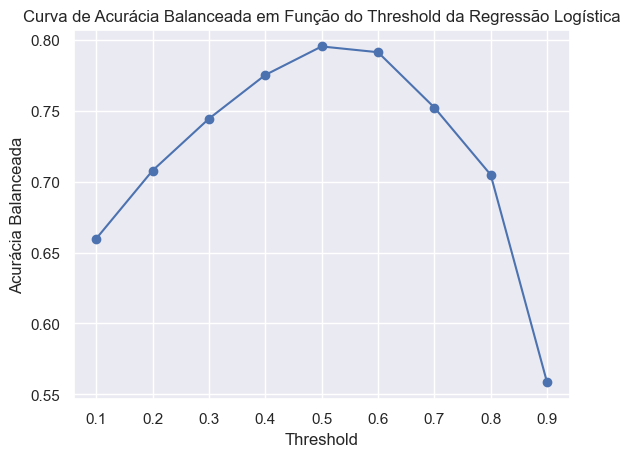

In [ ]:
ajustar_threshold(lr,x_scaler_train, y_train, x_scaler_val, y_val)

In [ ]:
dict_model = {}

In [ ]:
y_prob = lr.predict_proba(x_scaler_test)[:, 1]
preds = (y_prob >= 0.51).astype('int')

balanced_accuracy_score(y_test, preds)

0.8120824173455752

In [ ]:
confusion_matrix(y_test, preds)

array([[524, 179],
       [  4,  29]], dtype=int64)

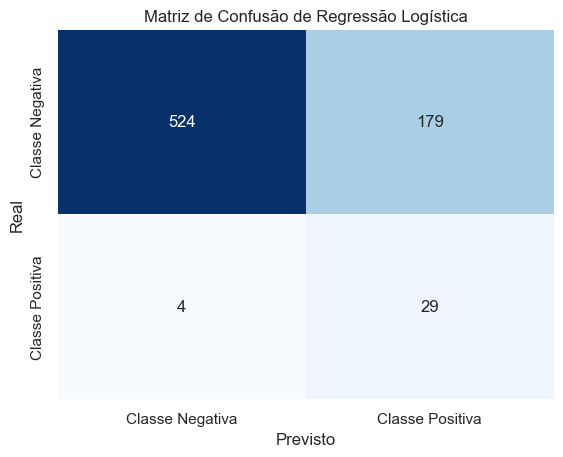

In [ ]:
cm = confusion_matrix(y_test, preds)

# Cria um heatmap usando seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe Negativa", "Classe Positiva"],
            yticklabels=["Classe Negativa", "Classe Positiva"])

plt.title('Matriz de Confusão de Regressão Logística')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()

In [ ]:
dict_model['LR'] = [lr, 0.51]
get_metrics(dict_model,x_scaler_test,y_test)

,LR
Overall AUC,0.859304
Balanced Accuracy,0.812082
Accuracy,0.751359
Precision,0.139423
Recall,0.878788
F1,0.240664
Specificity,0.745377
Sensitivity,0.878788
------,
Threshold,0.51


In [ ]:
bal_acc = balanced_accuracy_score(y_test, preds)
bal_acc
#auc = roc_auc_score(y_val,y_prob)

0.8120824173455752

In [ ]:
# def plot_roc_curve(fpr, tpr):
#     plt.plot(fpr, tpr, color='orange', label='ROC')
#     plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve')
#     plt.legend()
#     plt.show()

# fpr, tpr, thresholds = roc_curve(y_val, y_prob)
# print(tpr)
# print(fpr)
# print(thresholds)
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = 0.5
# print("Threshold value is:", optimal_threshold)
# plot_roc_curve(fpr, tpr)

## Random Forest

In [ ]:
# def objective_rf(trial):

#     # Definição dos Hiperparâmetros a serem otimizados
#     # threshold = trial.suggest_float('threshold',0.3,0.7)
#     threshold = 0.1
#     n_estimators = trial.suggest_int('n_estimators', 50, 200)
#     max_depth = trial.suggest_int('max_depth', 2, 30)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2'])
#     class_weight = trial.suggest_categorical('class_weight',['balanced',None])

#     # Definição da Técnica
#     clf = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42
#     )
#     # Métricas
#     clf.fit(x_scaler_train, y_train)
#     y_prob = clf.predict_proba(x_scaler_val)[:,1]
#     preds = (y_prob>= threshold).astype('int')
#     bal_acc = balanced_accuracy_score(y_val, preds)
#     #auc = roc_auc_score(y_val,y_prob)
#     return bal_acc

# # Métodos
# # Criando um objeto de estudo do Optuna
# study_rf = optuna.create_study(direction='maximize')

# # Otimizando os hiperparâmetros com o método 'objective' definido acima
# study_rf.optimize(objective_rf, n_trials=500,show_progress_bar=True,n_jobs=-1)
# study_dict = study_rf.best_params
# # Obter um DataFrame dos trials
# # trials_df = study_rf.trials_dataframe()

# # caminho_arquivo = 'C:\\Users\\decio\\Py D\\HIAAC\\Auditing_codes\\logs\\'
# # nome_arquivo = 'PAKDD_Trials_RF.csv'
# # # Exportar para um arquivo CSV
# # trials_df.to_csv(caminho_arquivo + nome_arquivo, index=False)

# # Printando os melhores hiperparâmetros e o valor da métrica acc_balanced associado
# print(study_rf.best_params)
# print("Best Balanced Acc: ",study_rf.best_value)

In [ ]:
study_dict = {'n_estimators': 183, 'max_depth': 22, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced'}

In [ ]:
rf = RandomForestClassifier(
        n_estimators=study_dict['n_estimators'], max_depth=study_dict['max_depth'],
        min_samples_split=study_dict['min_samples_split'],
        min_samples_leaf=study_dict['min_samples_leaf'],
        random_state=42,
        class_weight = study_dict['class_weight']
    )
rf.fit(x_scaler_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=22,
                       min_samples_leaf=7, min_samples_split=15,
                       n_estimators=183, random_state=42)

Melhor Threshold: 0.2
Acurácia Final: 0.686141304347826
Matriz de Confusão:
[[474 229]
 [  2  31]]


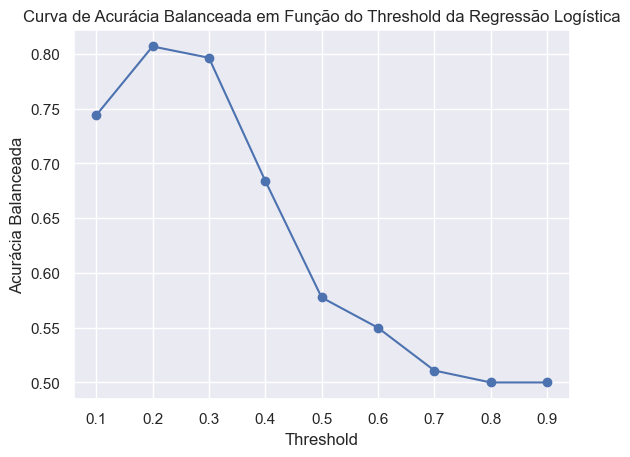

In [ ]:
ajustar_threshold(rf,x_scaler_train,y_train,x_scaler_test,y_test)

In [ ]:
y_prob = rf.predict_proba(x_scaler_test)[:, 1]
preds = (y_prob >= 0.251).astype('int')

balanced_accuracy_score(y_test, preds)

0.8430966852019484

In [ ]:
dict_model['RF'] = [rf,0.252]
get_metrics(dict_model,x_scaler_test,y_test)

,LR,RF
Overall AUC,0.859304,0.872451
Balanced Accuracy,0.812082,0.843097
Accuracy,0.751359,0.755435
Precision,0.139423,0.148325
Recall,0.878788,0.939394
F1,0.240664,0.256198
Specificity,0.745377,0.746799
Sensitivity,0.878788,0.939394
------,,
Threshold,0.51,0.252


In [ ]:
confusion_matrix(y_test, preds)

array([[525, 178],
       [  2,  31]], dtype=int64)

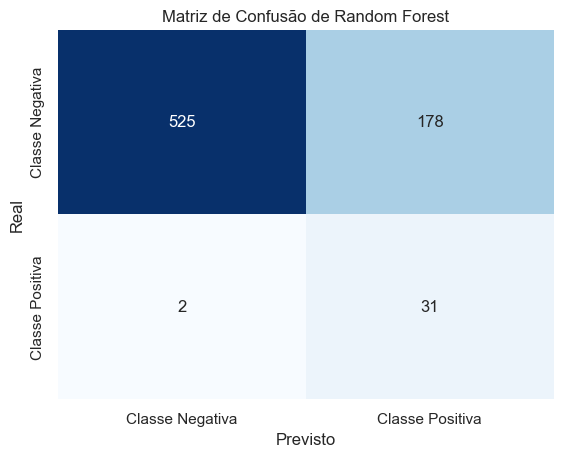

In [ ]:
cm = confusion_matrix(y_test, preds)

# Cria um heatmap usando seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Classe Negativa", "Classe Positiva"],
            yticklabels=["Classe Negativa", "Classe Positiva"])

plt.title('Matriz de Confusão de Random Forest')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.show()